# Time Series Final Project

This report is based on the excel spreadsheet named "data_exam.xlsx".

_Authors: Sarra Ben Yahia & José Ángel García Sánchez_


### Library of used functions :


In [1]:
import pandas as pd
import numpy as np
import numpy.matlib


# Time series analysis and modeling
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from statsmodels.tsa.api import VAR

# Probability distributions and statistical functions
from scipy.stats import norm

# Data visualization
import matplotlib.pyplot as plt

# Other libraries
from sklearn.linear_model import LinearRegression


In [2]:
def visualize_time_series(df):
    """
    Visualize each time series in the DataFrame.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        DataFrame containing the time series data to be visualized.

    Returns
    -------
    None
    """
    fig, axes = plt.subplots(nrows=len(df.columns),
                             ncols=1, dpi=120, figsize=(10, 6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(df.index, data, linewidth=1)
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
        plt.tight_layout()


In [3]:
def test_stationarity(df):
    """
    Perform ADF and KPSS tests on each column of the DataFrame
    """
    for col in df.columns:
        print(f'------------Testing column: {col}------------')

        # ADF test
        result_adf = adfuller(df[col])
        print('------------ ADF Statistic: %f' % result_adf[0])
        print('p-value: %f' % result_adf[1])
        for key, value in result_adf[4].items():
            print('Critical Value %s: %.3f' % (key, value))

        # KPSS test
        result_kpss = kpss(df[col])
        print('------------ KPSS Statistic: %f' % result_kpss[0])
        print('p-value: %f' % result_kpss[1])
        for key, value in result_kpss[3].items():
            print('Critical Value %s: %.3f' % (key, value))

        # Check if the time series is stationary or not
        if result_adf[1] < 0.05 and result_kpss[1] > 0.05:
            print("The time serie is stationary.")
        else:
            print("The time serie is not stationary.")

        print(' ' * 50)


In [4]:
def ML_HAR(para, x, plot=False):
    """
    Maximum likelihood function for HAR model optimization

    Parameters
    ----------
    para : array-like
        Array of HAR model parameters.
    x : pandas.core.series.Series
        Time series data to be fitted with the HAR model.
    plot : bool, optional
        If True, plot the time series data and the fitted values.

    Returns
    -------
    float
        Negative of the criterion function to be minimized by the optimization algorithm.
    """

    # Extract parameters
    phi0 = para[0]
    phi1 = para[1]
    phi2 = para[2]
    phi3 = para[3]

    # Computing moving averages
    ma5 = x.rolling(5).mean().shift(1)
    ma20 = x.rolling(20).mean().shift(1)
    ma1 = x.shift(1)

    # Combine the original series and the moving averages
    combination = pd.concat([x, ma1, ma5, ma20], axis=1)
    combination = np.log(combination)
    combination = combination.dropna()
    combination.columns = ['ini', 'ma1', 'ma5', 'ma20']

    # Calculate expected values using the HAR model
    expected = phi0 + phi1 * \
        combination['ma1'] + phi2 * combination['ma5'] + \
        phi3 * combination['ma20']

    # Combine the original series and the expected values
    temp = pd.concat([combination['ini'], expected], axis=1)

    # Calculate error and standard deviation of error
    error = combination['ini'] - expected
    sigma = np.nanstd(error)

    # Calculate density of error distribution
    density = norm.pdf(combination['ini'], expected, sigma)

    # Calculate criterion function to be minimized
    criterion = np.nansum(np.log(density))

    # Plot the data and the expected values if plot == True
    if plot == True:
        temp.plot()

    # Return the negative of the criterion function (to be minimized)
    return -criterion


In [5]:
def ML_HAR_fitted_values(para, x):
    """
    Returns the fitted values of a HAR model for a given set of parameters
    Args:
        para (list): A list of 4 parameters used to fit the model.
        x (pandas.DataFrame): A pandas DataFrame containing the time series data.
        plot (bool): Whether to plot the fitted values or not (default: False).
    Returns:
        pandas.DataFrame: A DataFrame containing the initial values of the time series and the fitted values.
    """

    # Extracting the parameters from the input list
    phi0 = para[0]
    phi1 = para[1]
    phi2 = para[2]
    phi3 = para[3]

    # Computing moving averages
    ma5 = x.rolling(5).mean().shift(1)
    ma20 = x.rolling(20).mean().shift(1)
    ma1 = x.shift(1)

    # Concatenating the moving averages into one DataFrame and taking the logarithm of the combination
    combination = pd.concat([x, ma1, ma5, ma20], axis=1)
    combination = np.log(combination)
    combination = combination.dropna()
    combination.columns = ['initial', 'ma1', 'ma5', 'ma20']

    # Computing the expected values using the input parameters and the logarithmic moving averages
    expected = phi0 + phi1 * \
        combination['ma1'] + phi2 * combination['ma5'] + \
        phi3 * combination['ma20']

    # Concatenating the initial values and the expected values into a DataFrame
    temp = pd.concat([combination['initial'], expected], axis=1)

    # Returning the initial values and the fitted values
    return temp[0]


In [6]:
def ar_order(ts, max_order):
    """
    Determine the order of an autoregressive (AR) model for a given time series based on maximum log-likelihood.

    Parameters:
    ts (pd.Series): Time series data
    max_order (int): Maximum order to consider for the AR model

    Returns:
    list: Log-likelihood values for each order from 1 to max_order
    """
    # Initialize an empty list to store log-likelihood values
    loglikelihood_values = []

    # Loop through all possible orders from 1 to max_order
    for order in range(1, max_order + 1):
        # Fit an AR model for the current order
        model = sm.AutoReg(ts, lags=order).fit()
        
        # Append the log-likelihood value of the fitted model to the list
        loglikelihood_values.append(model.llf)

    # Return the list of log-likelihood values
    return loglikelihood_values


In [7]:
def plot_acf_pacf(df):
    """
    Plots the ACF and PACF for each column of the input DataFrame.
    Args:
        df (pandas.DataFrame): The DataFrame containing the time series data.
    Returns:
        None.
    """
    for col in df.columns:
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
        plot_acf(df[col].dropna(), ax=ax[0])
        ax[0].set(title=f'ACF of {col}')
        plot_pacf(df[col].dropna(), ax=ax[1])
        ax[1].set(title=f'PACF of {col}')
        plt.show()


In [8]:
from scipy.stats import multivariate_normal


def ML_VAR(theta, X):
    """
    Calculates the log-likelihood of a VAR model.

    Parameters
    ----------
    theta : array-like
        Vector of model parameters.
    X : pandas.core.frame.DataFrame
        Matrix of time series data.

    Returns
    -------
    float
        Negative of the log-likelihood to be minimized by the optimization algorithm.
    """

    # Extract parameters from the theta vector
    Phi1 = [[theta[0], theta[1], theta[2]],
            [theta[3], theta[4], theta[5]],
            [theta[6], theta[7], theta[8]]]
    Phi0 = [[theta[9], theta[10], theta[11]]]

    # Create lagged data matrices Y and Z
    Y = X.iloc[1:X.shape[0], :]
    Z = X.iloc[0:X.shape[0] - 1, :]

    # Compute predicted values based on parameters
    Phi0_temp = np.matlib.repmat(Phi0, Z.shape[0], 1)
    temp = np.matmul(Z, Phi1) - Phi0_temp

    # Compute residuals and log-likelihood
    res = np.subtract(Y, temp)
    loglik = multivariate_normal.logpdf(
        res, mean=[0, 0, 0], cov=np.identity(3))
    loglik = -np.sum(loglik)

    return loglik


In [54]:
df = pd.read_excel("./data_exam.xlsx", index_col=0)
df.describe()


,VIX,Parkinson,Squared returns
count,5822.000000,5822.000000,5822.000000
mean,20.191311,0.000156,0.000145
std,8.674953,0.000575,0.000342
min,9.140000,0.000000,0.000001
25%,13.970000,0.000005,0.000026
50%,18.230000,0.000030,0.000061
75%,23.930000,0.000120,0.000138
max,82.690000,0.019919,0.006161


# 1. Explain the concept behind each column. What are these time series meant to represent? Trans- form these time series so that they are comparable in scale and order.


#### Introduction

In this report, we will analyze the joint relationship between three time series: parkinson and VIX estimators with squared returns. To better understand this relationship, we will convert all series to annual variances, as variances are closely linked to squared returns. In contrast, volatilities have a natural relationship with absolute returns. Squared returns is a proxy for the variance of the returns.

#### Why Use Parkinson and VIX Estimators to Explain Squared Returns?

The estimated historical volatility $\sigma$ of returns only captures linear relationships and assumes all events are equally weighted. In financial markets, volatility estimates based on a small dataset might lead to noisy measurements of the estimator due to sampling errors. Conversely, a large dataset uses information that is no longer relevant to the present state of the market. Therefore, using historical volatility as an exact number may not represent the actual value.

To address this problem, alternative volatility estimators that use all data points other than closing prices, such as Close-to-Close, Garman and Klass (GK), Parkinson’s, Rogers and Satchell (RS), and Garman and Klass–Yang and Zhang (GK-YZ), can be used. In this report, we will focus on Parkinson and VIX estimators, they are widely used and provide a good balance between accuracy and computational efficiency.

The Parkinson estimator is based on the high and low prices, while the VIX estimator is based on the implied volatilities of S&P 500 index options. By comparing their performance in explaining squared returns, we can gain insights into the joint relationship between these time series.

#### Parkinson estimator

The Parkinson estimator is widely used to transform returns from a daily to an intraday frequency. As we learned in class, having intraday series can be extremely expensive, often costing up to 10k€ per series. Thus, a good approach is to use the Parkinson estimator to approximate intraday returns and obtain a well-explained variability of returns.

The Parkinson estimator is a simplified version of the Garman Klass method, which includes a time component between the opening and closing prices. However, the Parkinson estimator is known for its high volatility, which can make it difficult to distinguish the signal from the noise. To overcome this issue, it is necessary to filter out the white noise from the information provided by the estimator. The Parkinson estimator is based on the high and low prices of a financial instrument and can be expressed as follows:

$$\sigma_{Parkinson} = \sqrt{\frac{1}{4n\ln2}\sum_{k=1}^n\left(\log\left(\frac{H_{k}}{L_{k}}\right)\right)^2}$$

#### Extension of parkinson estimator

Even if the Parkinson estimate of variance is unbiased for continuous prices, prices are only sampled discretely. Then another approach or extension to using the Parkinson estimator could be to consider more accurate volatility estimators. According to [volatilites mesures article](https://www.mdpi.com/1099-4300/24/10/1410), while the Parkinson estimator is five times more efficient than the close-to-close estimator, the Garman Klass method is 7.4 times more efficient than close-to-close. Garman-Klass estimator (GK) is given by:

$$\sigma_{GK} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\frac{1}{2}\left(\frac{\Delta H_i}{C_i} - \frac{\Delta L_i}{C_i}\right)^2 - (2\ln2 - 1)\left(\frac{\Delta C_i}{C_i}\right)^2\right)}$$

Moreover, an even more recent and improved version of the Garman Klass method is the Yang and Zhang developed version of GK (YZ-GK estimator), which provides even better accuracy and efficiency. The estimator is given by:

$$\sigma_{YZ-GK} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\alpha\left(\frac{\Delta H_i}{C_i}\right)^2 + (1-\alpha)\left(\frac{\Delta C_i}{C_i}\right)^2 - 2\beta\left(\frac{\Delta H_i}{C_i}\right)\left(\frac{\Delta C_i}{C_i}\right)\right)}$$

#### Parkison transformation

To annualize the Parkinson variance, we can multiply the daily variance by 252, since there are 252 trading days in a year. This transformation is given by the following formula:

$$\sigma_{Annualised\ Parkinson}^2 = \sigma_{Daily\ Parkinson}^2 * 252$$

#### VIX

The VIX (CBOE Volatility Index) is a measure of the expected 30-day volatility of the U.S. stock market, derived from the prices of S&P 500 index options. It represents the market's expectation of near-term volatility. In our case VIX is expressed as percentage points.

#### VIX transformations  
To yield volatility from percentage value we do:

$$\sigma_{VIX} = \frac{VIX\ Value}{100}$$

then to have annualised variance we do:
$$\sigma_{Annualised\ VIX}^2 = \sigma_{VIX}*\left(\sqrt{\frac{252}{30}}\right)^2$$


In [10]:
df_annualised = pd.DataFrame({
    'VIX_variance': ((df['VIX'] / 100) * np.sqrt(252/30))**2,
    'parkinson_variance': df['Parkinson'] * 252,
    'squared_returns': df['Squared returns'] * 252
})


In [11]:
df_diff = df_annualised.diff().dropna()
df_diff.columns = [f"{col}_diff" for col in df_annualised.columns]


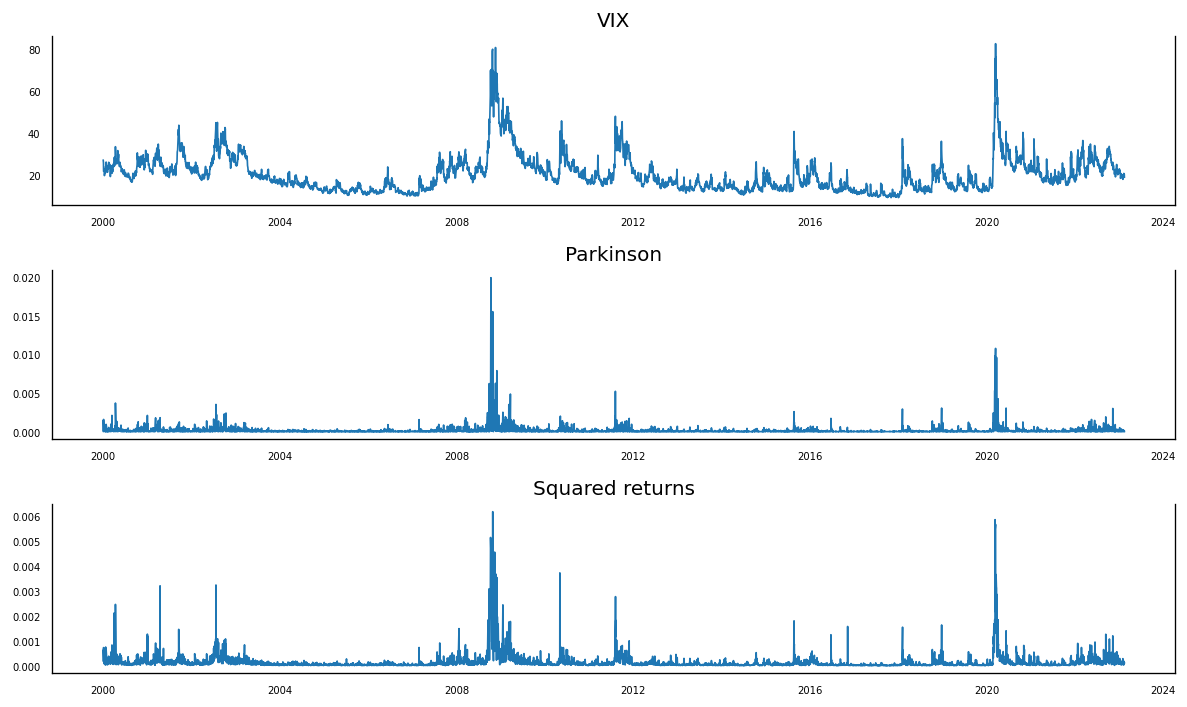

In [12]:
visualize_time_series(df)


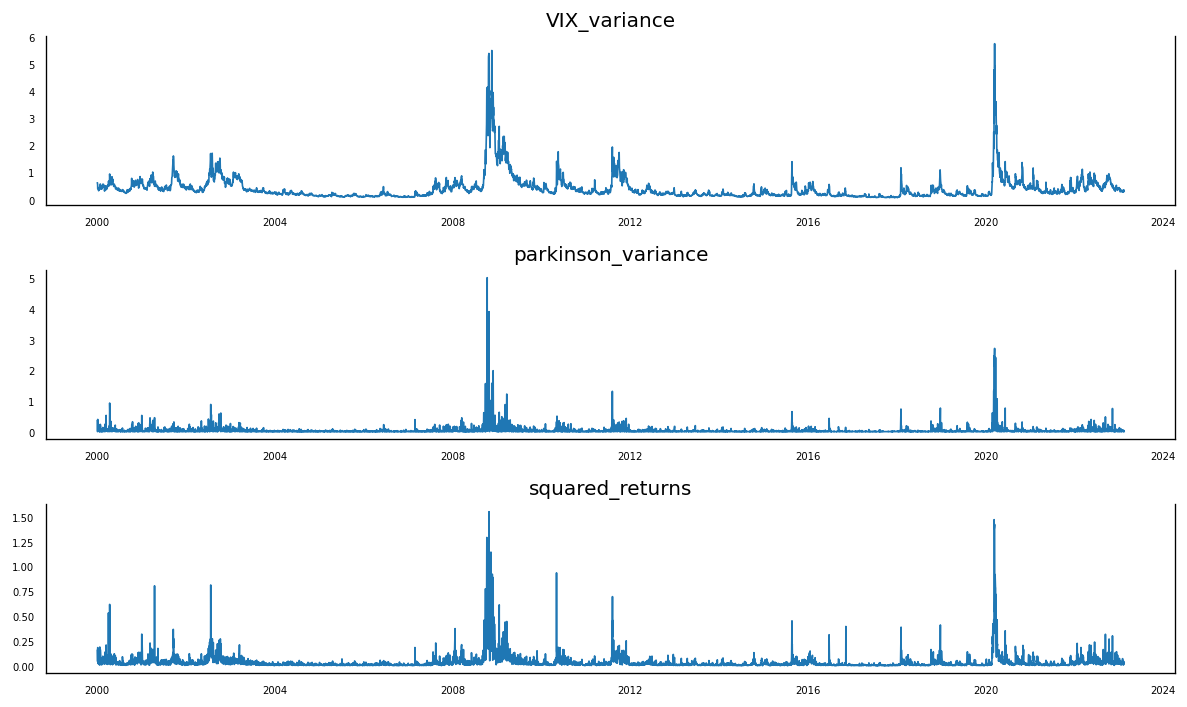

In [13]:
visualize_time_series(df_annualised)


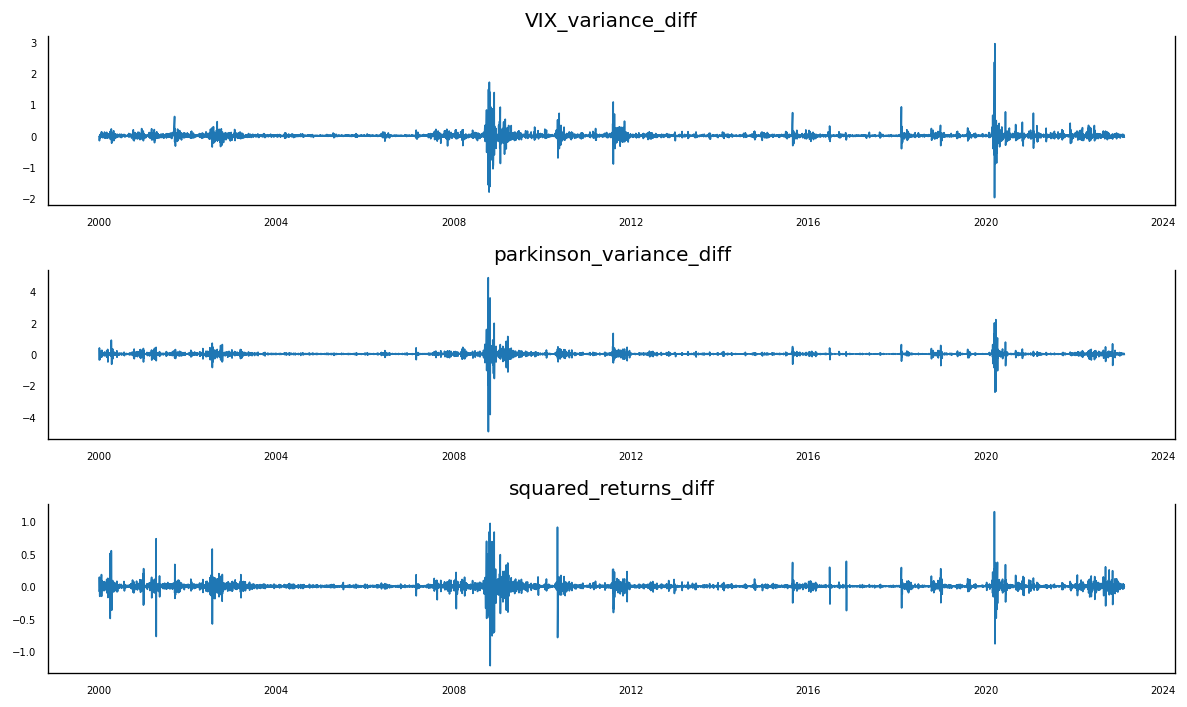

In [14]:
visualize_time_series(df_diff)


# 2. Estimate and AR model on each of these time series. Determine the order of the AR process and show the estimates. What can you conclude from these estimations? (2 points) and 3. Plot the fitted values for each model vs. the original time series. Why are these fitted values appealing for volatility measuring purposes? (2 points)


The returns are known for beeing non-Gaussian. The returns are known for showing a low degree of linear correlation when computed on the raw-returns (when we talk about non-intra-day time scale). Eventhough, when we look at a nonlinear transformation of the returns, then it presents an autocorrelation that is slowly decaying with time. Then in our case, for squared returns, the first results of AR must show it.

Returns are also known to present volatility clusters, where periods of low-volatily are followed by periods of low-volatility and periods with high-volatily are followed by periods with high-volatility. They present also the famous leverage effect. The leverage effect is the special caracteristic of returns that says that returns are negatively correlated with volatility. The modern approch is to treat moments as time-varying.

Returns are then non-stationnary and present fat tails. Volatility of returns presents a persistence which has been exploted by GARCH literature in the 1980s.

As we have seen during the course, for returns the only moment that presents persistence is volatility, the second-moment. For example, the first moment never presents persistence due to the facility to predict the returns in the future and then markets would profit from this anomaly.

Il y a des gens qui utilisent la skewness et le kurtosis au lieu du premier et deuxième moment dans les séries centrées et normalisées.
Skewness and kurtosis may be expressed as the ratio of centered normalized moments. Financial returns have in general a negative skewness and a pronounced excess kurtosis


In [15]:
# # Pour prendre le df annualisé
vix, parkinson, squared_returns = df_annualised[[
     'VIX_variance', 'parkinson_variance', 'squared_returns']].values.T

# Pour prendre le df annualisé et différencié
#vix, parkinson, squared_returns = df_diff[[
#    'VIX_variance_diff', 'parkinson_variance_diff', 'squared_returns_diff']].values.T


/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


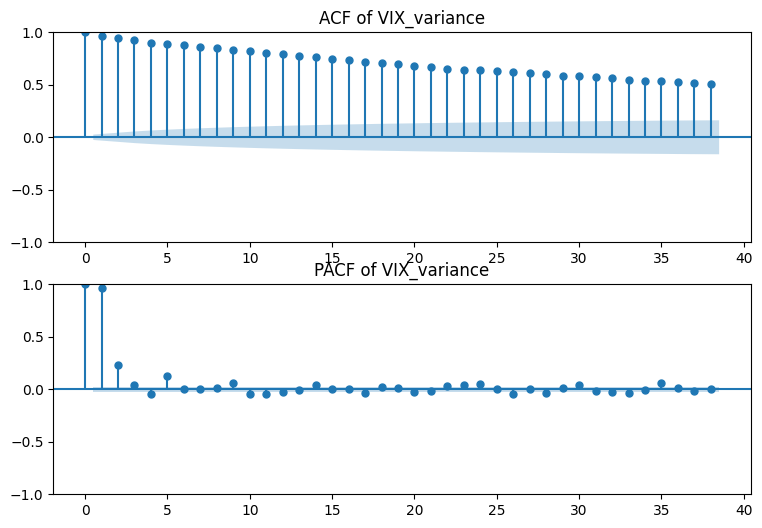

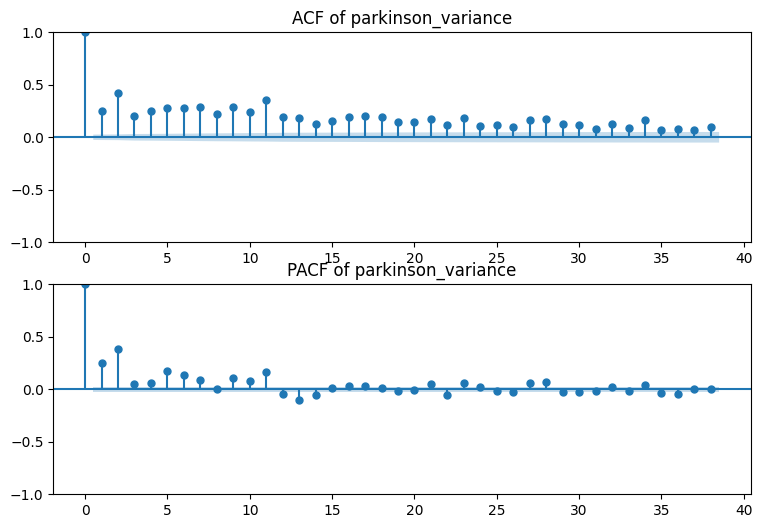

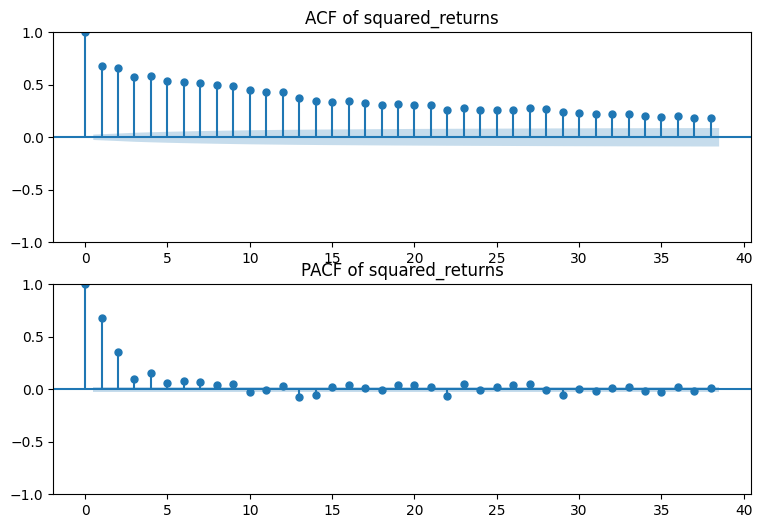

In [16]:
plot_acf_pacf(df_annualised)


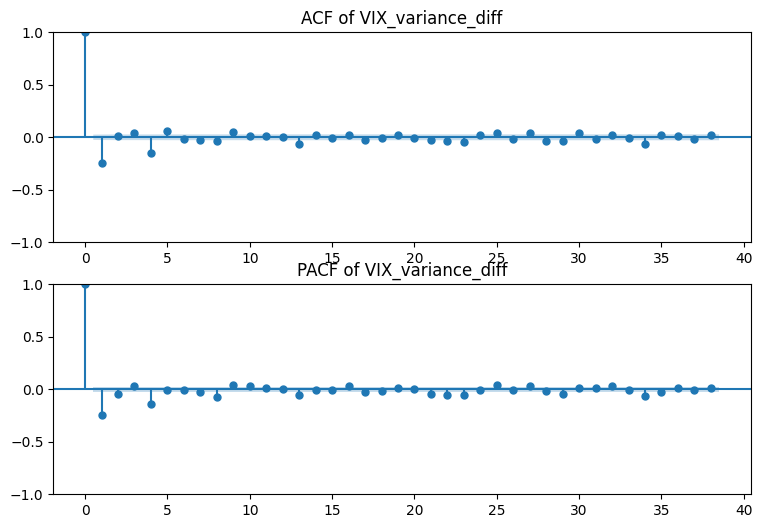

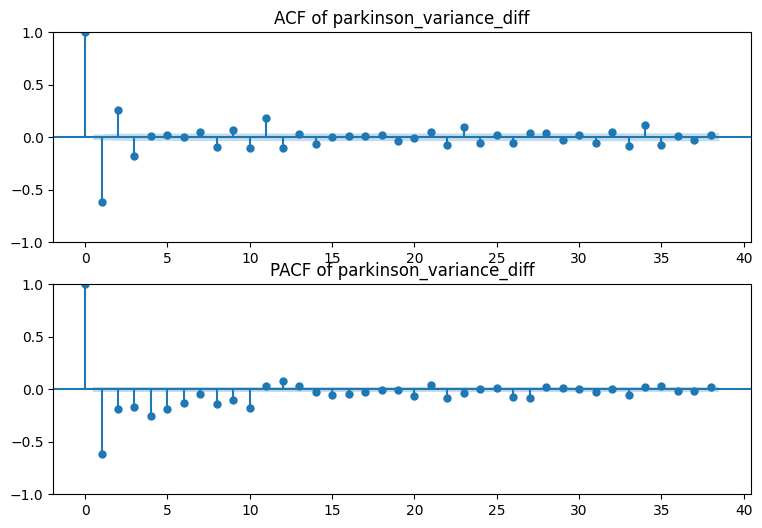

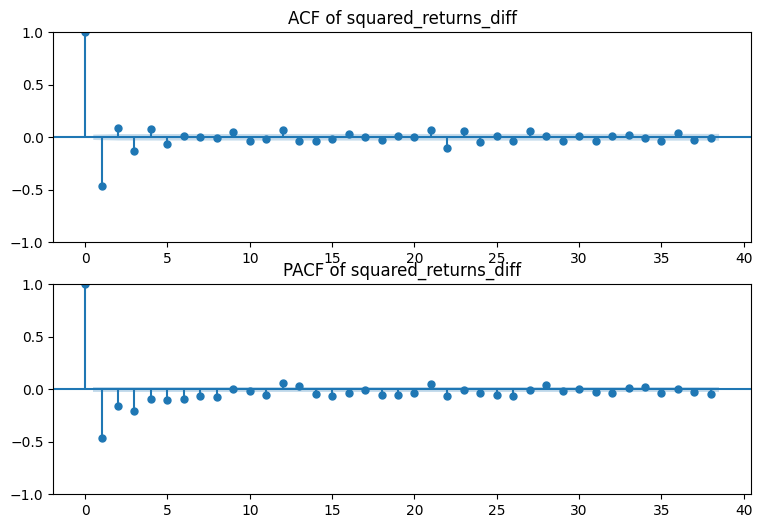

In [17]:
plot_acf_pacf(df_diff)


elles sont stationnaires car elles ont ete traité par la variance et l'annualisation
ici on a le rendement qui a deja ete calcule du coup c'est stationnaire

In [53]:
test_stationarity(df_annualised)


------------Testing column: VIX_variance------------
------------ ADF Statistic: -6.091627
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.383261
p-value: 0.084370
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is stationary.
                                                  
------------Testing column: parkinson_variance------------
------------ ADF Statistic: -8.185235
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.169003
p-value: 0.100000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is stationary.
                                                  
------------Testing column: squared_returns------------
------------ ADF Statistic: -8.214812
p-value: 0.000000
Critical Value 1%: -3.431


The time series are stationnary, we can compute the order of the AR model according to log-likelihood criterions


In [19]:
import statsmodels.tsa.api as sm
import warnings
warnings.filterwarnings("ignore")

# Estimate AR model order for each time series
vix_loglikelihood = ar_order(vix, 4)
parkinson_loglikelihood = ar_order(parkinson, 4)
squared_returns_loglikelihood = ar_order(squared_returns, 4)

# Find the order that maximizes the log-likelihood
vix_order = np.argmax(vix_loglikelihood) 
parkinson_order = np.argmax(parkinson_loglikelihood) 
squared_returns_order = np.argmax(squared_returns_loglikelihood) 

# Fit AR model with chosen lag order
vix_ar_model = sm.AutoReg(vix, lags=vix_order).fit()
parkinson_ar_model = sm.AutoReg(parkinson, lags=parkinson_order).fit()
squared_returns_ar_model = sm.AutoReg(squared_returns, lags=squared_returns_order).fit()

# Print estimated coefficients
print('------------VIX AR({}) model coefficients:------------'.format(vix_order))
print(vix_ar_model.params)
print('Log-Likelihood :', vix_loglikelihood[np.argmax(vix_loglikelihood)] )
print('\n------------Parkinson AR({}) model coefficients:------------'.format(parkinson_order))
print(parkinson_ar_model.params)
print('Log-Likelihood :', parkinson_loglikelihood[np.argmax(parkinson_loglikelihood)] )
print('\n------------Squared returns AR({}) model coefficients:------------'.format(squared_returns_order))
print(squared_returns_ar_model.params)
print('Log-Likelihood :', squared_returns_loglikelihood[np.argmax(squared_returns_loglikelihood)]  )


------------VIX AR(3) model coefficients:------------
[0.01092126 0.7325039  0.2042115  0.0362231 ]
Log-Likelihood : 4210.495719319767

------------Parkinson AR(3) model coefficients:------------
[0.01720672 0.13613454 0.37351657 0.05222026]
Log-Likelihood : 3656.415943729741

------------Squared returns AR(3) model coefficients:------------
[0.00671225 0.40231178 0.3167662  0.09748062]
Log-Likelihood : 8340.1969935828


In [20]:
# Generate predicted values based on AR models
ar_models = [vix_ar_model, parkinson_ar_model, squared_returns_ar_model]
ar_preds = [model.predict() for model in ar_models]
vix_ar_pred, parkinson_ar_pred, squared_returns_ar_pred = ar_preds


les rendements ont pas de memoire mais les volatilite ont une memoire
c pas choquant ca va 

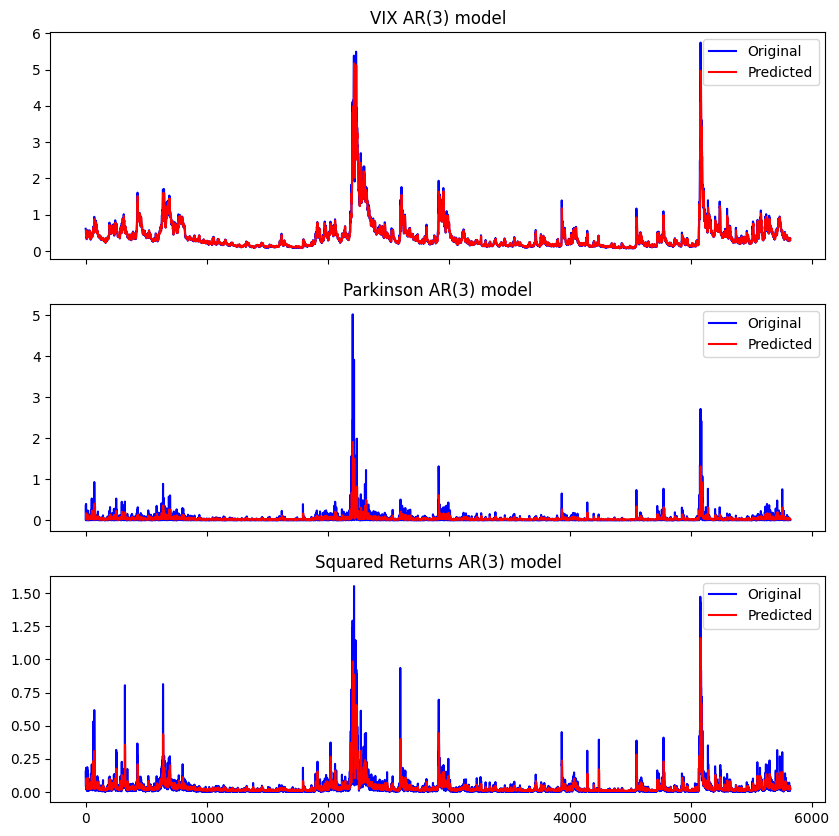

In [21]:
# Plot original time series and fitted values
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# VIX series
axes[0].plot(vix, color='blue', label='Original')
axes[0].plot(vix_ar_pred, color='red', label='Predicted')
axes[0].set_title('VIX series')
axes[0].set_title('VIX AR({}) model'.format(vix_order))
axes[0].set_xticklabels([])
axes[0].set_xticklabels([])
axes[0].legend()
axes[0].legend()

# Parkinson series
axes[1].plot(parkinson, color='blue', label='Original')
axes[1].plot(parkinson_ar_pred, color='red', label='Predicted')
axes[1].set_title('Parkinson series')
axes[1].set_title('Parkinson AR({}) model'.format(parkinson_order))
axes[1].set_xticklabels([])
axes[1].set_xticklabels([])
axes[1].legend()
axes[1].legend()

# Squared returns series
axes[2].plot(squared_returns, color='blue', label='Original')
axes[2].plot(squared_returns_ar_pred, color='red', label='Predicted')
axes[2].set_title('Squared Returns series')
axes[2].set_title('Squared Returns AR({}) model'.format(squared_returns_order))
axes[2].legend()
axes[2].legend()

plt.show()


NOTES : regarder si les résidus sont normaux pour dire que c une bonne estimation ou pas

# 4. Estimate an HAR model on each time series. Present the estimated coefficients of the model and compare the loglikelihood of each model to the one obtained from the AR estimations. Which model do you prefer? (4 points). Retain the fitted values of the model you have selected for each of the three time series.


Most HAR-type models use a fixed lag index of 
 to mirror the daily, weekly, and monthly components of the volatility process, but they ignore model specification uncertainty

In [22]:
#  if annualised
vix = df_annualised['VIX_variance']
parkinson = df_annualised['parkinson_variance']
squared_returns = df_annualised['squared_returns']

### VIX


In [23]:
x0 = np.array([-1,1,0.5,2])
res_EV = minimize(ML_HAR, x0, method='BFGS', args=vix,
                  hess=True, options={'disp': True})


         Current function value: -3169.624755
         Iterations: 25
         Function evaluations: 332
         Gradient evaluations: 64


-3169.624754939986

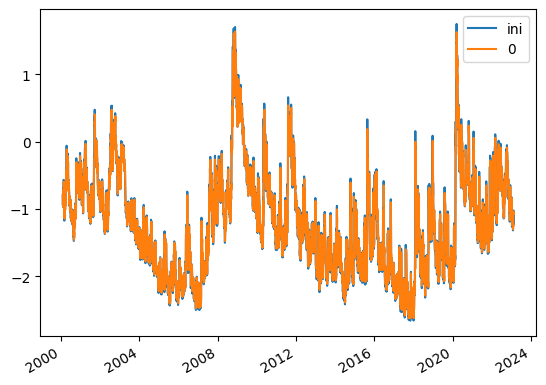

In [24]:
ML_HAR(res_EV.x, vix, True)


In [25]:
fitted_vix = ML_HAR_fitted_values(res_EV.x, vix)


### Parkinson


NOTES SARRA : Il y a beaucoup de volatilité sur Parkinson, il faut découper le bruit blanc


reg 
residus estime qui vont qvoir des retards
on doit avoir le modele ar + la partie heteroscedastique + bruit blanc estimes 
EN GROS C MA_NOISE

In time series analysis, white noise refers to random fluctuations in the data that are uncorrelated over time. These fluctuations can be caused by a variety of factors, including measurement error, environmental noise, or other sources of randomness.

White noise can be a problem for time series analysis because it can obscure underlying patterns or trends in the data. One way to deal with this problem is to use smoothing techniques like moving averages or exponential smoothing to reduce the impact of the noise and reveal the underlying signal.

In the case of a Parkinson's variance series, we might be interested in understanding the underlying trends or patterns in the variance of the disease over time. However, this variance might be affected by random fluctuations or measurement error, which can make it difficult to discern any underlying patterns.

To reduce the impact of white noise in this series, we can use a smoothing technique like a moving average or exponential smoothing to smooth out the short-term fluctuations in the data and reveal the underlying trend. By doing so, we can improve our ability to analyze and model the variance of the disease over time, which can help us to better understand its progression and potential treatments.

In [26]:
# Choose a window size of 2
window_size = 2

# Apply a moving average to the series
moving_average = parkinson.rolling(window=window_size).mean()

# Replace the original series with the moving average
parkinson_smoothed = moving_average


In [50]:
x0 = np.array([1,.8,-1,1])
res_EV = minimize(ML_HAR, x0, method='BFGS', args=
    parkinson_smoothed, hess=True, options={'disp': True})

         Current function value: 9726.543649
         Iterations: 15
         Function evaluations: 262
         Gradient evaluations: 50


9726.543649174399

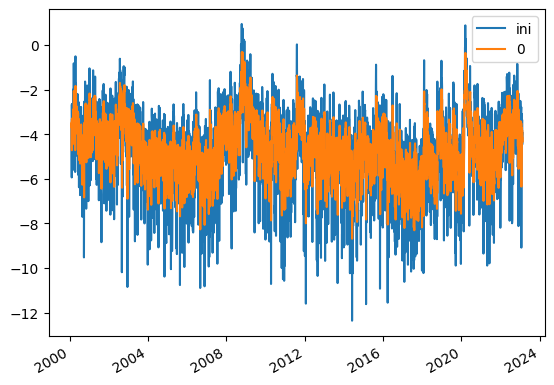

In [51]:
ML_HAR(res_EV.x, parkinson_smoothed, True)


In [52]:
fitted_parkinson = ML_HAR_fitted_values(res_EV.x, parkinson_smoothed)

### Squared returns


In [30]:
x0 = np.array([1,.8,-1,1])
res_EV = minimize(ML_HAR, x0, method='BFGS', args=
    squared_returns, hess=True, options={'disp': True})


         Current function value: 6979.159745
         Iterations: 18
         Function evaluations: 185
         Gradient evaluations: 37


6979.159744829696

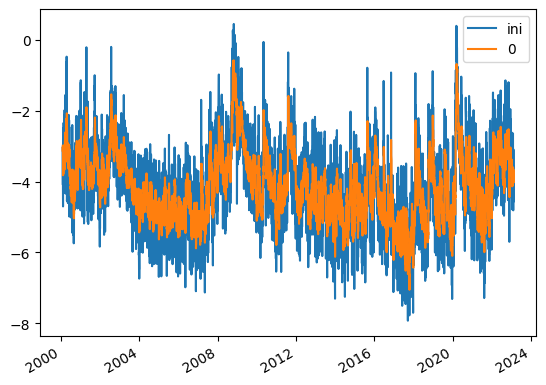

In [31]:
ML_HAR(res_EV.x, squared_returns, True)


In [32]:
fitted_returns = ML_HAR_fitted_values(res_EV.x, squared_returns)

In [33]:
df_har = pd.DataFrame()
df_har["vix"] = fitted_vix
df_har["parkinson"] = fitted_parkinson
df_har["squared_returns"] = fitted_returns
df_har.dropna(inplace=True)


ICI IL FAUT FAIRE LE CHOIX ENTRE HAR ET AR

# 5. Test for the stationnarity of the esimtated time series. Comment your results. (3 points)


là faut mettre le df avec le modèle choisis

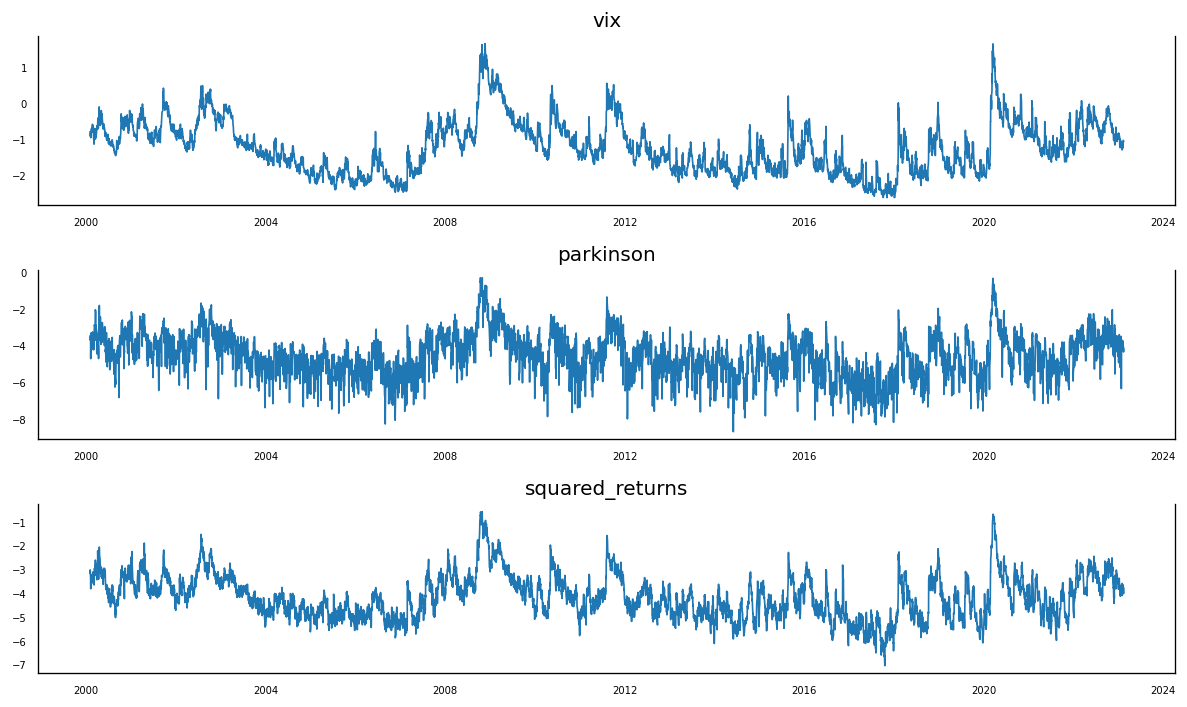

In [34]:
visualize_time_series(df_har)


In [35]:
df_har.describe()

,vix,parkinson,squared_returns
count,5801.000000,5801.000000,5801.000000
mean,-1.219397,-4.526898,-4.156988
std,0.724124,1.189760,0.924421
min,-2.620162,-8.687526,-7.052051
25%,-1.801444,-5.308052,-4.853828
50%,-1.281040,-4.521797,-4.221915
75%,-0.742975,-3.718837,-3.528459
max,1.633396,-0.317029,-0.587873


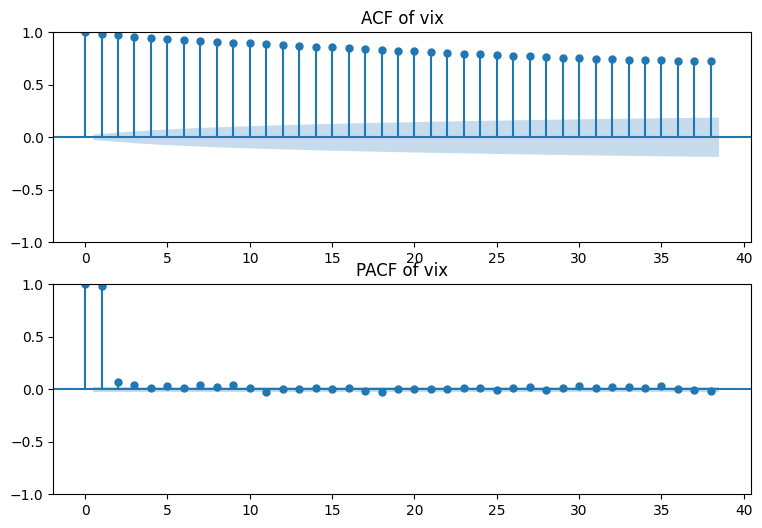

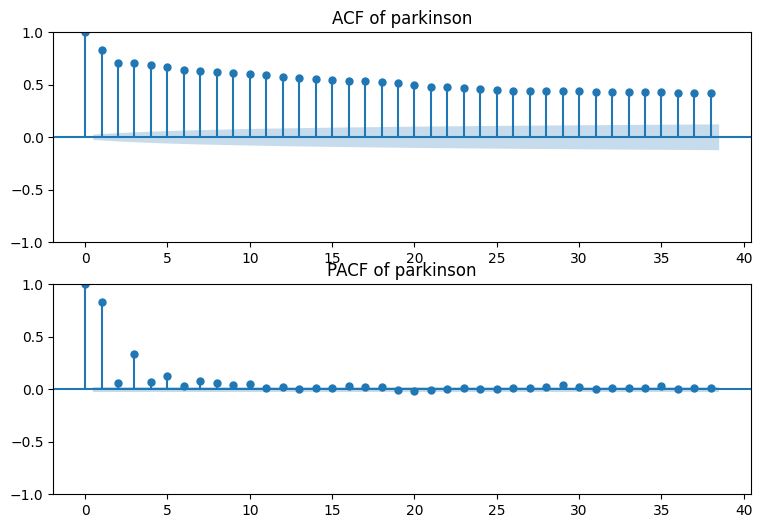

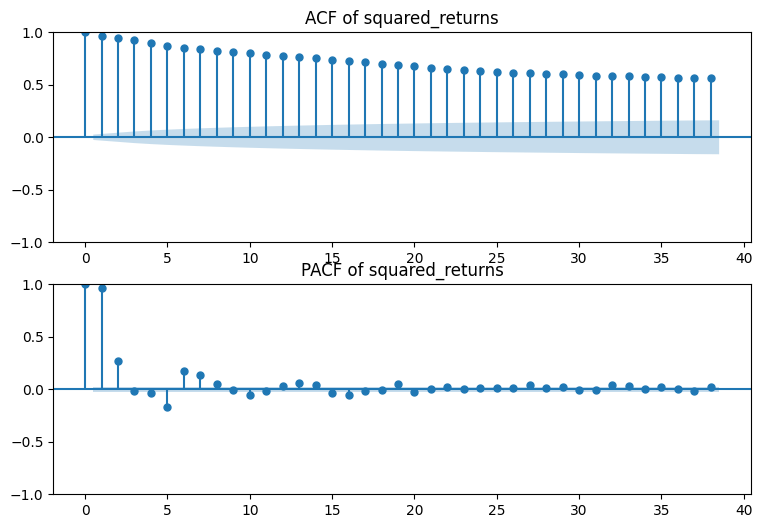

In [36]:
plot_acf_pacf(df_har)


In [37]:
test_stationarity(df_har)


------------Testing column: vix------------
------------ ADF Statistic: -5.046177
p-value: 0.000018
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.806753
p-value: 0.010000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is not stationary.
                                                  
------------Testing column: parkinson------------
------------ ADF Statistic: -7.025821
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.860828
p-value: 0.010000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is not stationary.
                                                  
------------Testing column: squared_returns------------
------------ ADF Statistic: -5.266892
p-value: 0.000006
Critical Value 1%: -3.431
Critical V

# 6. Estimate a VAR(p) model on your three stationnary fitted values. Comment your results. (4 points)


NOTES SARRA : IL FAUT MODELISER QUE LES SERIES STATIONNAIRES


### Step 1 : Transforming the fitted values to be stationnary


In [38]:
df_har_stationnary = df_har.diff().dropna()


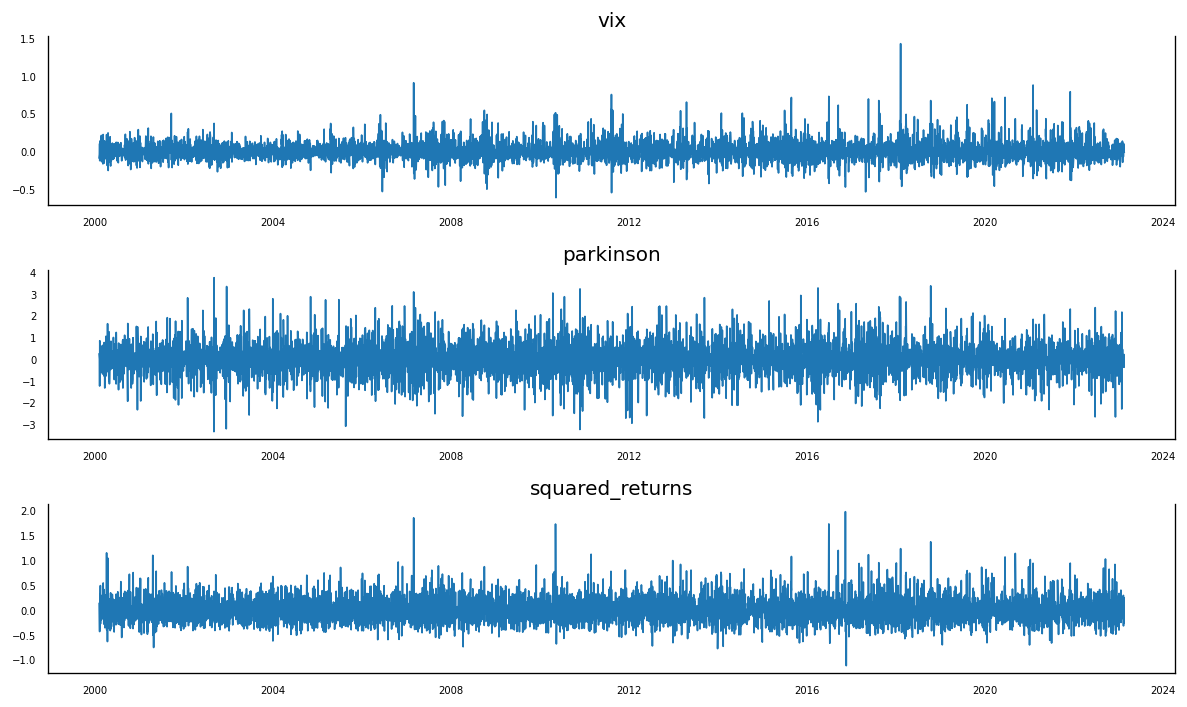

In [39]:
visualize_time_series(df_har_stationnary)


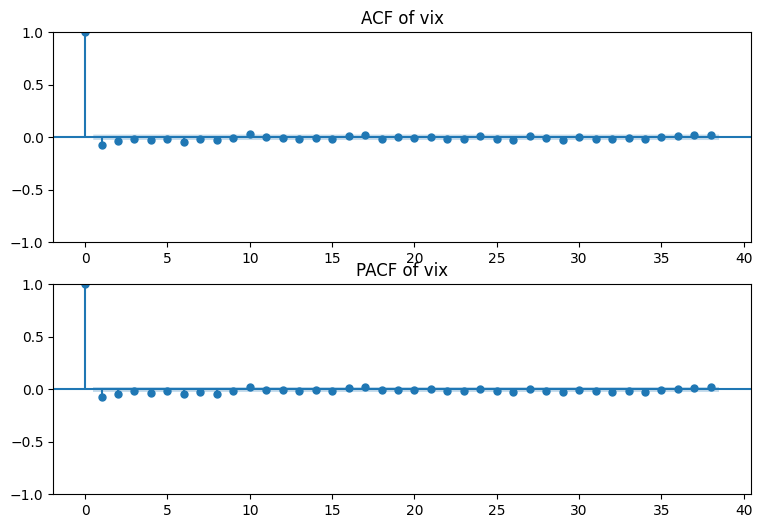

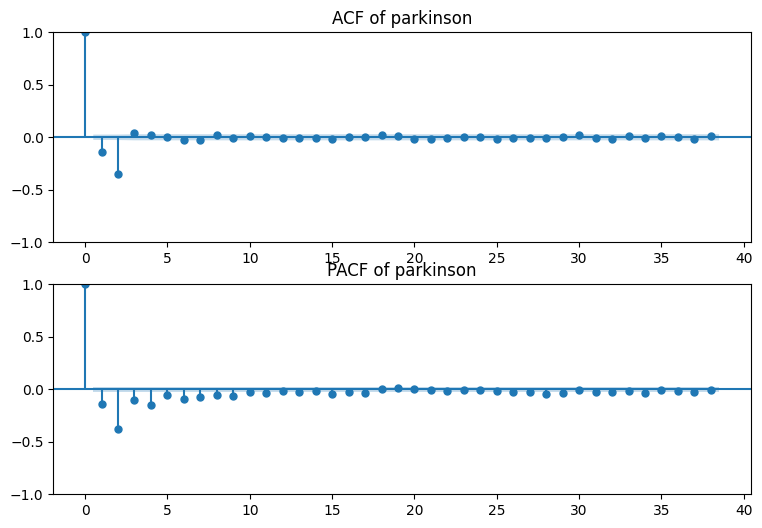

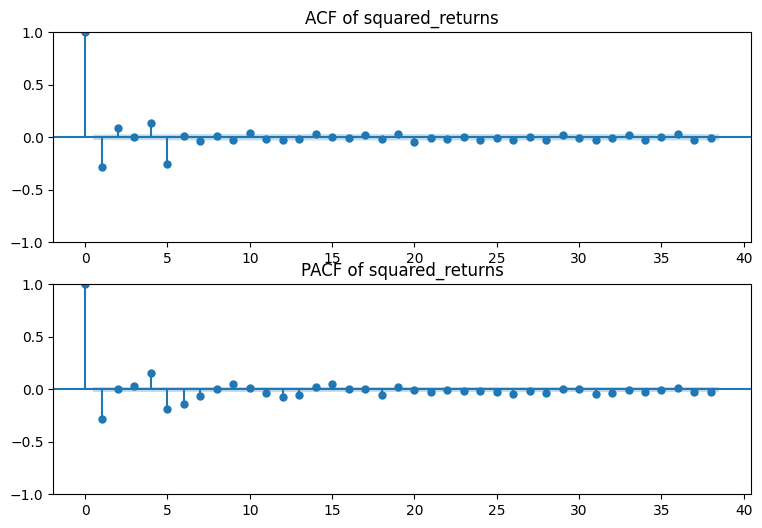

In [40]:
plot_acf_pacf(df_har_stationnary)


In [41]:
test_stationarity(df_har_stationnary)


------------Testing column: vix------------
------------ ADF Statistic: -31.376271
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.013143
p-value: 0.100000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is stationary.
                                                  
------------Testing column: parkinson------------
------------ ADF Statistic: -18.529672
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.021787
p-value: 0.100000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is stationary.
                                                  
------------Testing column: squared_returns------------
------------ ADF Statistic: -17.795514
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 

### Step 2 : Estimation of the VAR


COMMENT CHOISIR LE LAG ????


equation simultanee
on veut voir limpact quune volaitlite peut avoir sur les autre
volaitilite 1 = volatilite2 t-1

In [42]:
model = VAR(df_har_stationnary)
# Order selection
x = model.select_order(40)
x.summary()


,AIC,BIC,FPE,HQIC
0,-7.783,-7.780,0.0004167,-7.782
1,-8.150,-8.136,0.0002886,-8.145
2,-8.338,-8.314,0.0002391,-8.330
3,-8.435,-8.401,0.0002170,-8.423
4,-8.541,-8.496,0.0001953,-8.525
5,-8.587,-8.532,0.0001865,-8.568
6,-8.635,-8.570,0.0001777,-8.612
7,-8.653,-8.577,0.0001746,-8.626
8,-8.664,-8.577,0.0001727,-8.634
9,-8.679,-8.582*,0.0001702,-8.645


NOTES SARRA : COMMENT ON CHOISIT LE LAG???


on prend le meilleur retard mais dans les serie ca va diverger 
yaura des pb dautocorrelation

on garde ca

In [43]:
# Fit the VAR model with lag order 2 and print the summary
model_fitted = model.fit(28)
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Apr, 2023
Time:                     00:03:10
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.44102
Nobs:                     5772.00    HQIC:                  -8.63289
Log likelihood:           894.685    FPE:                0.000160812
AIC:                     -8.73528    Det(Omega_mle):     0.000153912
--------------------------------------------------------------------
Results for equation vix
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.000084         0.001677           -0.050           0.960
L1.vix                     -0.095770         0.014155           -6.766           0.000
L1.parkinson               -0.001759  

on vire durbin watson

In [44]:
# Test for serial correlation in the residuals using Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

# Print the Durbin-Watson test statistic for each variable
for col, val in zip(df_har_stationnary.columns, out):
    print(f'Durbin Watson t-stat for {col}:', round(val, 2))


Durbin Watson t-stat for vix: 2.0
Durbin Watson t-stat for parkinson: 2.01
Durbin Watson t-stat for squared_returns: 2.0


NOTE SARRA : A value of 2 indicates no serial correlation, while values less than 2 indicate positive serial correlation, and values greater than 2 indicate negative serial correlation.


In [45]:
# Get the lag order of the VAR model
lag_order = model_fitted.k_ar
print('Lag order:', lag_order)


Lag order: 28


In [46]:
# Extract the estimated coefficients for the lagged endogenous variables and the exogenous variables
Phi1 = model_fitted.coefs
Phi0 = model_fitted.coefs_exog

# Flatten the coefficient matrices into a 1-dimensional array
theta = [*Phi1.flatten(), *Phi0.flatten()]

# Compute the log-likelihood of the estimated model parameters
loglik = ML_VAR(theta, df_har_stationnary)

# Print the log-likelihood value
print("Log-likelihood:", loglik)


Log-likelihood: 19201.583181150738


In [47]:
# Estimate the parameters of the VAR model using maximum likelihood
estimation_output = minimize(
    ML_VAR, theta, method='BFGS', args=df_har_stationnary)
estimated_para = estimation_output.x
standard_deviation = np.power(np.diag(estimation_output.hess_inv), .5)
t_stat = estimated_para / standard_deviation

# Create a new DataFrame to store the t-statistics
t_stat_df = pd.DataFrame({'t-stat': t_stat})

# Iterate over the rows of the DataFrame and highlight significant t-statistics
for i, row in t_stat_df.iterrows():
    if np.abs(row['t-stat']) < 1.96:
        # Green for significant
        t_stat_df.loc[i,
                      't-stat'] = f'\033[1m\033[32m{row["t-stat"]:.2f}\033[0m'
    else:
        # Red for non-significant
        t_stat_df.loc[i,
                      't-stat'] = f'\033[1m\033[31m{row["t-stat"]:.2f}\033[0m'

# Print the t-statistics of the estimated parameters with highlighting
print(t_stat_df)


                  t-stat
0     -0.75
1     -1.48
2      5.08
3     -0.03
4    -11.73
..                   ...
250   -0.01
251   -0.04
252   -0.00
253   -0.00
254   -0.00

[255 rows x 1 columns]


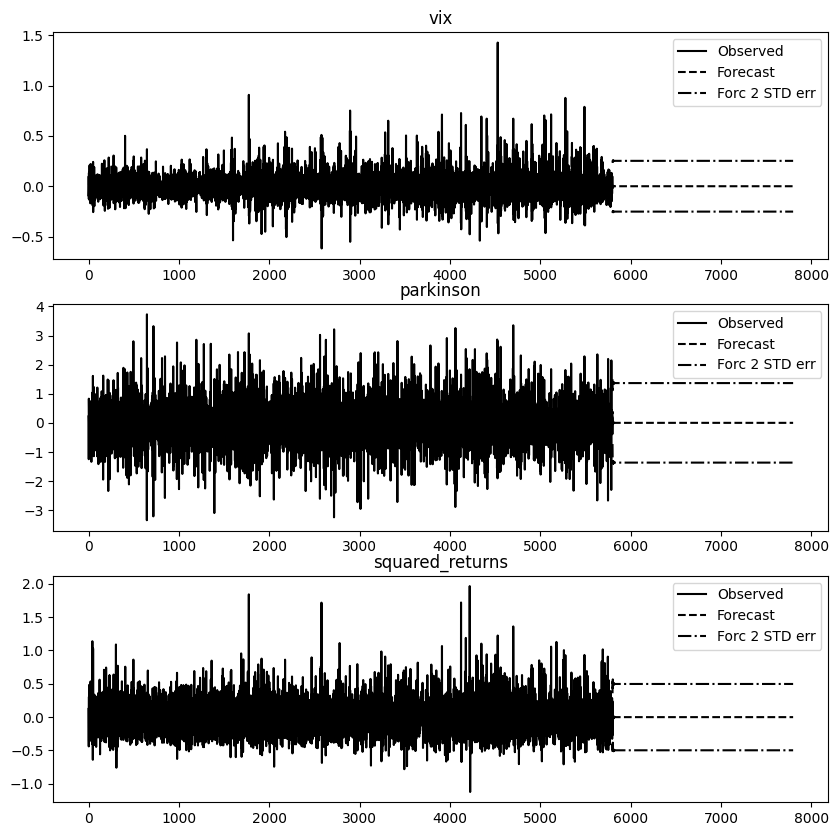

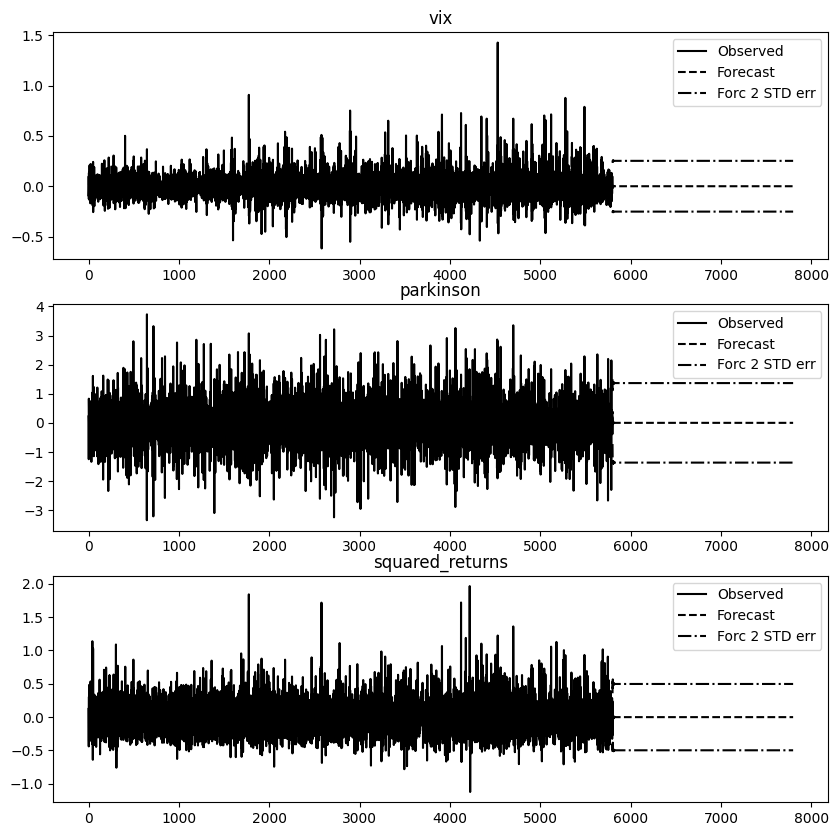

In [48]:
# Generate a forecast for the next 200 time steps
model_fitted = model.fit(12)
forecast_horiz = 2000
forecast = model_fitted.forecast(
    df_har_stationnary.values[-lag_order:], forecast_horiz)
model_fitted.plot_forecast(forecast_horiz)


# 7. Plot an impulse response function obtained from your VAR model and comment the results (4 points)


ON CHOQUE SUR COMBIEN DE PERIODES ??


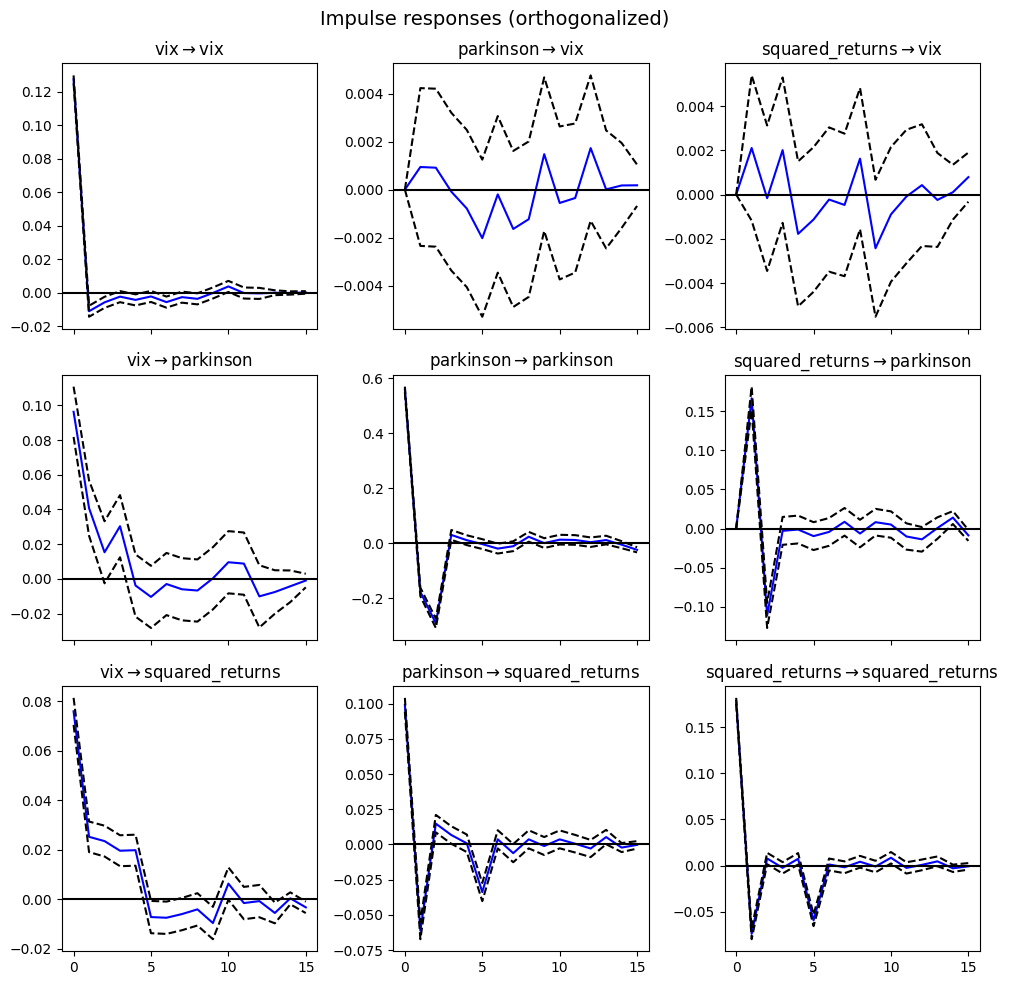

In [49]:
# Compute the impulse response function (IRF) for 15 periods
irf = model_fitted.irf(15)

# Plot the IRFs with orthogonalized shocks
irf.plot(orth=True)

# Adjust the layout of the plots for better readability
plt.tight_layout()
